In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Primeramente cargamos el dataframe de las reviews

In [31]:
data=pd.read_csv('steam_reseñas.csv')

## Dropeamos los Nan para la prueba

In [32]:
print(data.isna().sum())
data_clean=data.dropna()

game_title             0
game_id                0
review                 0
recommended            0
no_stopwords           4
clean_text             4
lemmatized_text        4
lemmatized_text_v2    92
dtype: int64


In [33]:
print(data_clean.isna().sum())

game_title            0
game_id               0
review                0
recommended           0
no_stopwords          0
clean_text            0
lemmatized_text       0
lemmatized_text_v2    0
dtype: int64


## Ahora vamos a ver si las clases están balanceadas

In [29]:
print(data_clean['recommended'].value_counts())

recommended
True     8807
False    6105
Name: count, dtype: int64


Como vemos las clases no están balanceadas, luego es preciso tener en cuenta esto a la hora de realizar los modelos para no emplear el umbral básico de sklearn y añadir en la estratificación de los datos este hecho para intentar que los conjuntos sean lo más homogéneos posible.

## Modelos

Empezamos empleando como vectorizador el bag of words y como modelos de prueba emplearemos uno de los más sencillos que será la regresión logística y luego con otro más complejo el XGBoost.


>> Mejor F1-score: 0.9536 con umbral: 0.55

>> Classification Report con mejor umbral:
              precision    recall  f1-score   support

       False       0.68      0.45      0.54       221
        True       0.93      0.97      0.95      1762

    accuracy                           0.92      1983
   macro avg       0.81      0.71      0.75      1983
weighted avg       0.91      0.92      0.91      1983



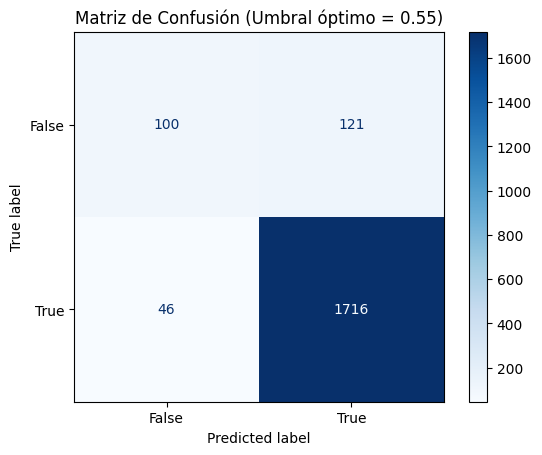

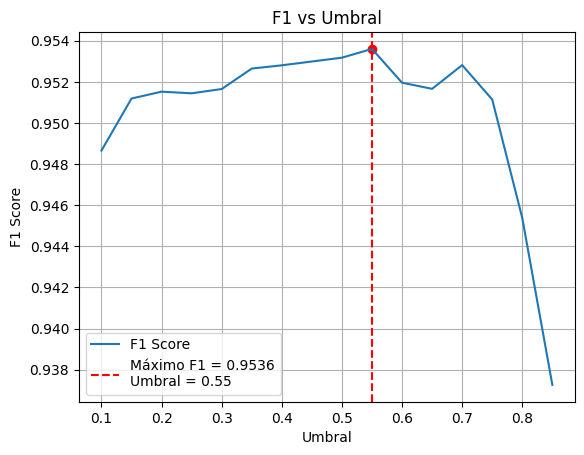

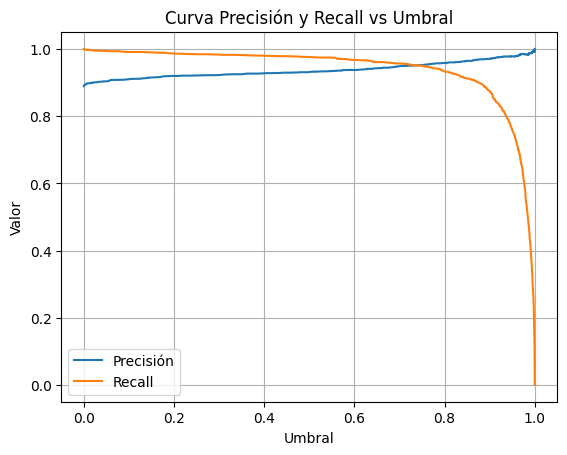

In [34]:
# 1. Prepara los datos
X = data_clean['review']  # textos
y = data_clean['recommended']  # etiquetas (True/False)

# 2. Divide en train/test con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Vectoriza los textos (Bag of Words)
vectorizer = CountVectorizer(max_features=2000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# 4. Entrena un modelo de regresión logística
clf = LogisticRegression(max_iter=1000, solver='liblinear')  # mejor para estabilidad
clf.fit(X_train_bow, y_train)

# 5. Predice probabilidades
y_proba = clf.predict_proba(X_test_bow)[:, 1]  # Probabilidad de clase positiva

# 6. Evalúa F1 con distintos umbrales
thresh = np.arange(0.1, 0.9, 0.05)
f1s = [f1_score(y_test, y_proba >= t) for t in thresh]

# Encuentra el umbral con mejor F1
max_f1 = max(f1s)
best_thresh = thresh[f1s.index(max_f1)]
print(f"\n>> Mejor F1-score: {max_f1:.4f} con umbral: {best_thresh:.2f}")

# 7. Reporte de clasificación para el mejor umbral
y_pred_best = (y_proba >= best_thresh)
print("\n>> Classification Report con mejor umbral:")
print(classification_report(y_test, y_pred_best))



# 7.5. Mostrar matriz de confusión para el mejor umbral
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title(f'Matriz de Confusión (Umbral óptimo = {best_thresh:.2f})')
plt.grid(False)
plt.show()
# 8. Curva de F1 vs Umbral (con el punto óptimo marcado)
plt.figure()
plt.plot(thresh, f1s, label='F1 Score')
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Máximo F1 = {max_f1:.4f}\nUmbral = {best_thresh:.2f}')
plt.scatter(best_thresh, max_f1, color='red')
plt.xlabel("Umbral")
plt.ylabel("F1 Score")
plt.title("F1 vs Umbral")
plt.legend()
plt.grid(True)
plt.show()

# 9. Curva de Precisión-Recall
precision, recall, thresh_pr = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(thresh_pr, precision[:-1], label='Precisión')
plt.plot(thresh_pr, recall[:-1], label='Recall')
plt.xlabel('Umbral')
plt.ylabel('Valor')
plt.title('Curva Precisión y Recall vs Umbral')
plt.legend()
plt.grid(True)
plt.show()


Ahora vamos a probar con el XGBoost


>> Mejor F1-score: 0.9566 con umbral: 0.45

>> Classification Report con mejor umbral:
              precision    recall  f1-score   support

       False       0.77      0.33      0.46       294
        True       0.93      0.99      0.96      2517

    accuracy                           0.92      2811
   macro avg       0.85      0.66      0.71      2811
weighted avg       0.91      0.92      0.90      2811



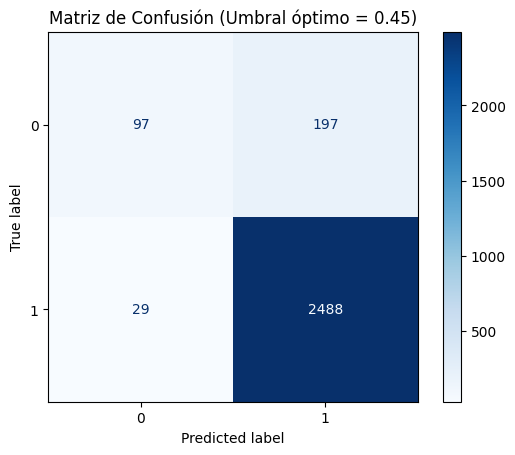

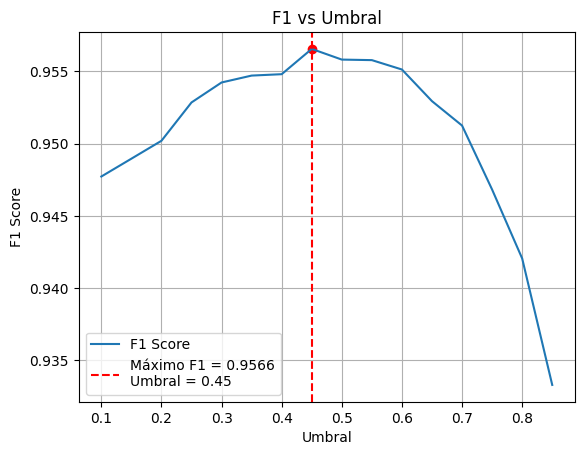

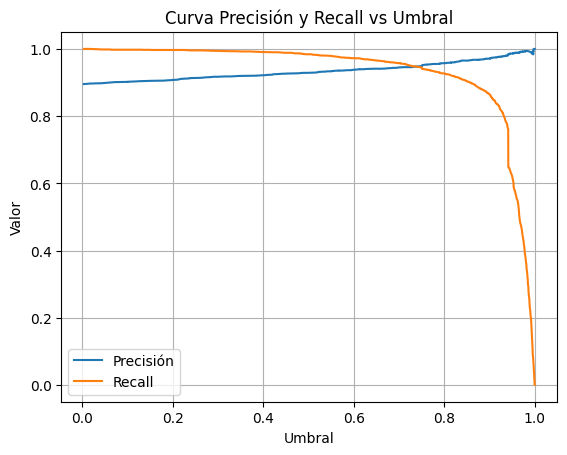

In [32]:
from xgboost import XGBClassifier 

# 4. Entrena modelo XGBoost
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
clf.fit(X_train_bow, y_train)

# 5. Predice probabilidades
y_proba = clf.predict_proba(X_test_bow)[:, 1]

# 6. Evalúa F1 con distintos umbrales
thresh = np.arange(0.1, 0.9, 0.05)
f1s = [f1_score(y_test, y_proba >= t) for t in thresh]
max_f1 = max(f1s)
best_thresh = thresh[f1s.index(max_f1)]
print(f"\n>> Mejor F1-score: {max_f1:.4f} con umbral: {best_thresh:.2f}")

# 7. Reporte de clasificación
y_pred_best = (y_proba >= best_thresh)
print("\n>> Classification Report con mejor umbral:")
print(classification_report(y_test, y_pred_best))

# 7.5. Matriz de confusión
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues')
plt.title(f'Matriz de Confusión (Umbral óptimo = {best_thresh:.2f})')
plt.grid(False)
plt.show()

# 8. Curva F1 vs Umbral
plt.figure()
plt.plot(thresh, f1s, label='F1 Score')
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Máximo F1 = {max_f1:.4f}\nUmbral = {best_thresh:.2f}')
plt.scatter(best_thresh, max_f1, color='red')
plt.xlabel("Umbral")
plt.ylabel("F1 Score")
plt.title("F1 vs Umbral")
plt.legend()
plt.grid(True)
plt.show()

# 9. Curva de Precisión-Recall
precision, recall, thresh_pr = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(thresh_pr, precision[:-1], label='Precisión')
plt.plot(thresh_pr, recall[:-1], label='Recall')
plt.xlabel('Umbral')
plt.ylabel('Valor')
plt.title('Curva Precisión y Recall vs Umbral')
plt.legend()
plt.grid(True)
plt.show()



## Ahora vamos a emplear tfidf como vectorizador


>> [TF-IDF + LogisticRegression] Mejor F1-score: 0.9588 con umbral: 0.65
              precision    recall  f1-score   support

       False       0.72      0.46      0.56       294
        True       0.94      0.98      0.96      2517

    accuracy                           0.92      2811
   macro avg       0.83      0.72      0.76      2811
weighted avg       0.92      0.92      0.92      2811



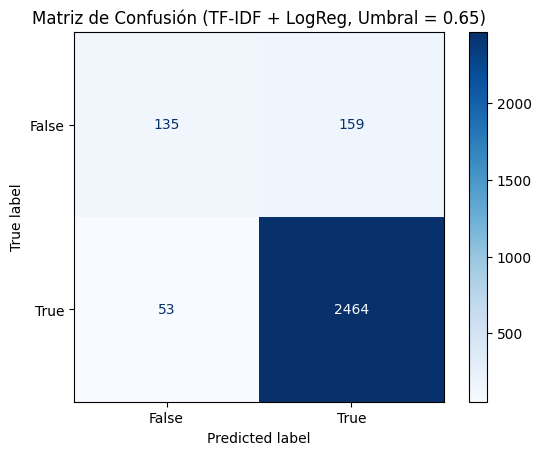

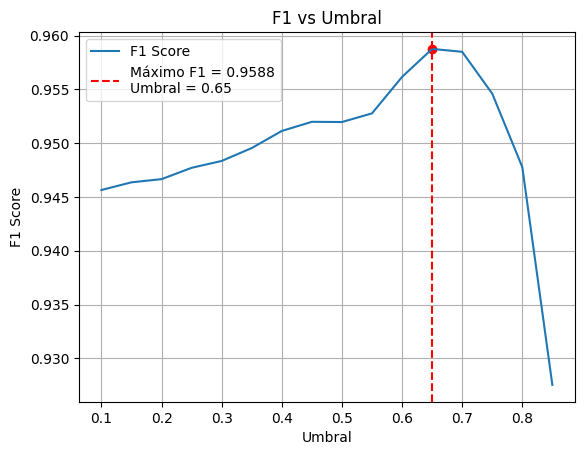

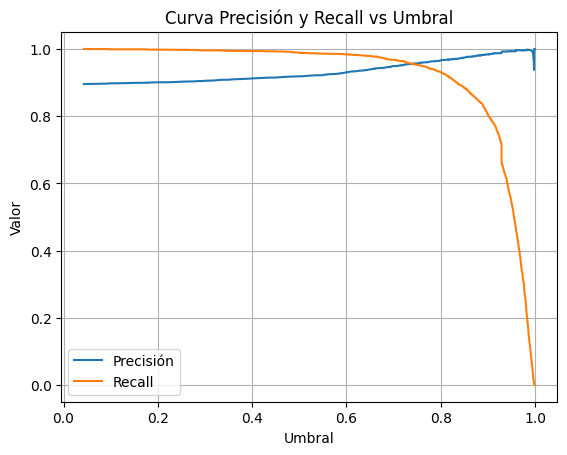

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 3. Vectoriza con TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 4. Entrena modelo de regresión logística
clf = LogisticRegression(max_iter=1000, solver='liblinear')
clf.fit(X_train_tfidf, y_train)

# 5. Predice probabilidades
y_proba = clf.predict_proba(X_test_tfidf)[:, 1]

# 6. Selección de umbral óptimo según F1
thresh = np.arange(0.1, 0.9, 0.05)
f1s = [f1_score(y_test, y_proba >= t) for t in thresh]
max_f1 = max(f1s)
best_thresh = thresh[f1s.index(max_f1)]
print(f"\n>> [TF-IDF + LogisticRegression] Mejor F1-score: {max_f1:.4f} con umbral: {best_thresh:.2f}")

# 7. Clasificación + matriz
y_pred_best = (y_proba >= best_thresh)
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot(cmap='Blues')
plt.title(f'Matriz de Confusión (TF-IDF + LogReg, Umbral = {best_thresh:.2f})')
plt.grid(False)
plt.show()

# 8. Curva F1 vs Umbral
plt.figure()
plt.plot(thresh, f1s, label='F1 Score')
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Máximo F1 = {max_f1:.4f}\nUmbral = {best_thresh:.2f}')
plt.scatter(best_thresh, max_f1, color='red')
plt.xlabel("Umbral")
plt.ylabel("F1 Score")
plt.title("F1 vs Umbral")
plt.legend()
plt.grid(True)
plt.show()

# 9. Curva de Precisión-Recall
precision, recall, thresh_pr = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(thresh_pr, precision[:-1], label='Precisión')
plt.plot(thresh_pr, recall[:-1], label='Recall')
plt.xlabel('Umbral')
plt.ylabel('Valor')
plt.title('Curva Precisión y Recall vs Umbral')
plt.legend()
plt.grid(True)
plt.show()


>> [TF-IDF + XGBoost] Mejor F1-score: 0.9532 con umbral: 0.65
              precision    recall  f1-score   support

       False       0.63      0.46      0.53       294
        True       0.94      0.97      0.95      2517

    accuracy                           0.91      2811
   macro avg       0.78      0.72      0.74      2811
weighted avg       0.91      0.91      0.91      2811



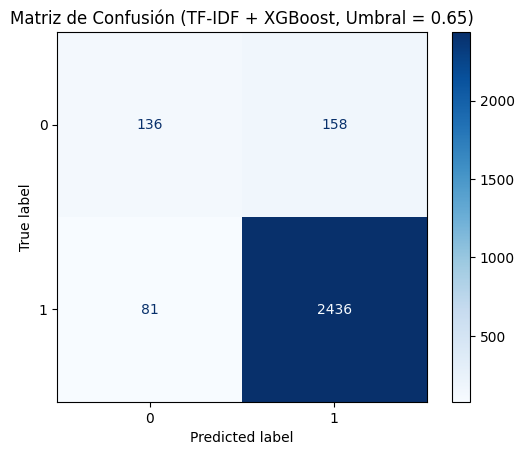

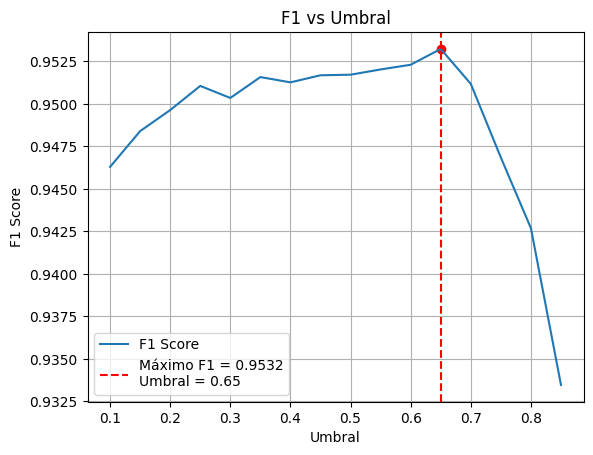

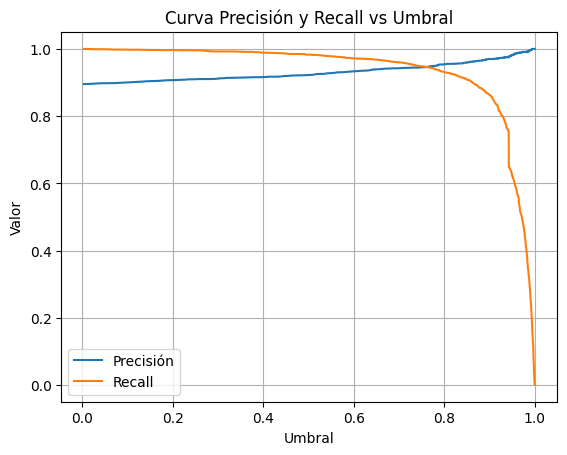

In [34]:
# 4. Entrena modelo XGBoost
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
clf.fit(X_train_tfidf, y_train)

# 5. Predice probabilidades
y_proba = clf.predict_proba(X_test_tfidf)[:, 1]

# 6. Selección de umbral óptimo según F1
thresh = np.arange(0.1, 0.9, 0.05)
f1s = [f1_score(y_test, y_proba >= t) for t in thresh]
max_f1 = max(f1s)
best_thresh = thresh[f1s.index(max_f1)]
print(f"\n>> [TF-IDF + XGBoost] Mejor F1-score: {max_f1:.4f} con umbral: {best_thresh:.2f}")

# 7. Clasificación + matriz
y_pred_best = (y_proba >= best_thresh)
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot(cmap='Blues')
plt.title(f'Matriz de Confusión (TF-IDF + XGBoost, Umbral = {best_thresh:.2f})')
plt.grid(False)
plt.show()

# 8. Curva F1 vs Umbral
plt.figure()
plt.plot(thresh, f1s, label='F1 Score')
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Máximo F1 = {max_f1:.4f}\nUmbral = {best_thresh:.2f}')
plt.scatter(best_thresh, max_f1, color='red')
plt.xlabel("Umbral")
plt.ylabel("F1 Score")
plt.title("F1 vs Umbral")
plt.legend()
plt.grid(True)
plt.show()

# 9. Curva de Precisión-Recall
precision, recall, thresh_pr = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(thresh_pr, precision[:-1], label='Precisión')
plt.plot(thresh_pr, recall[:-1], label='Recall')
plt.xlabel('Umbral')
plt.ylabel('Valor')
plt.title('Curva Precisión y Recall vs Umbral')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
%pip install tabulate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
from tabulate import tabulate
# Configuraciones a evaluar
vectorizers = {
    "CountVectorizer": CountVectorizer(max_features=2000),
    "TfidfVectorizer": TfidfVectorizer(max_features=2000)
}

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
}

# Evaluación
resultados = []

for vec_name, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    for model_name, model in models.items():
        model.fit(X_train_vec, y_train)
        y_proba = model.predict_proba(X_test_vec)[:, 1]

        # Buscar mejor umbral según F1
        thresholds = np.arange(0.1, 0.9, 0.05)
        f1s = [f1_score(y_test, y_proba >= t) for t in thresholds]
        best_f1 = max(f1s)
        best_thresh = thresholds[f1s.index(best_f1)]

        # Guardar resultado
        resultados.append({
            "Modelo": model_name,
            "Vectorizador": vec_name,
            "F1-score": round(best_f1, 4),
            "Umbral óptimo": round(best_thresh, 2)
        })

# Crear DataFrame
df_resultados = pd.DataFrame(resultados)


# Mostrar la tabla con formato bonito
tabla_bonita = tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False)
print(tabla_bonita)

╒════════════════════╤═════════════════╤════════════╤═════════════════╕
│ Modelo             │ Vectorizador    │   F1-score │   Umbral óptimo │
╞════════════════════╪═════════════════╪════════════╪═════════════════╡
│ LogisticRegression │ CountVectorizer │     0.9583 │            0.6  │
├────────────────────┼─────────────────┼────────────┼─────────────────┤
│ XGBoost            │ CountVectorizer │     0.9566 │            0.45 │
├────────────────────┼─────────────────┼────────────┼─────────────────┤
│ LogisticRegression │ TfidfVectorizer │     0.9588 │            0.65 │
├────────────────────┼─────────────────┼────────────┼─────────────────┤
│ XGBoost            │ TfidfVectorizer │     0.9532 │            0.65 │
╘════════════════════╧═════════════════╧════════════╧═════════════════╛


# Vamos a probar con el random forest para intentar mejorar para clases desbalanceadas


>> [TF-IDF + RandomForest] Mejor F1-score: 0.9483 con umbral: 0.50
              precision    recall  f1-score   support

       False       0.67      0.15      0.24       294
        True       0.91      0.99      0.95      2517

    accuracy                           0.90      2811
   macro avg       0.79      0.57      0.59      2811
weighted avg       0.88      0.90      0.87      2811



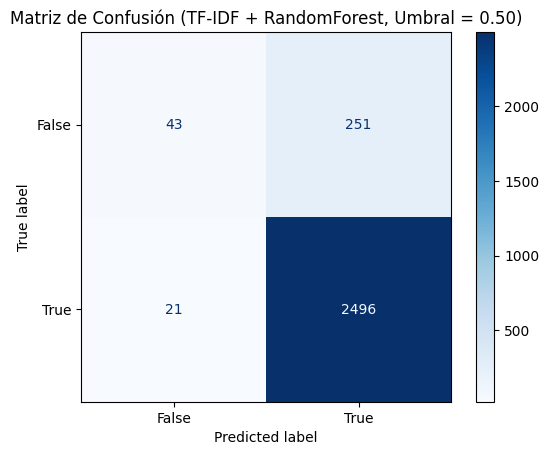

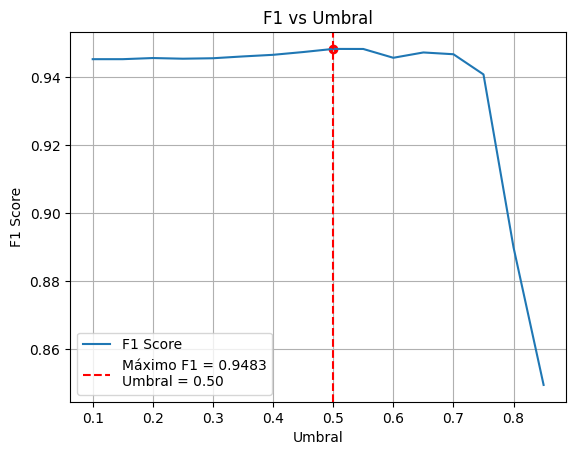

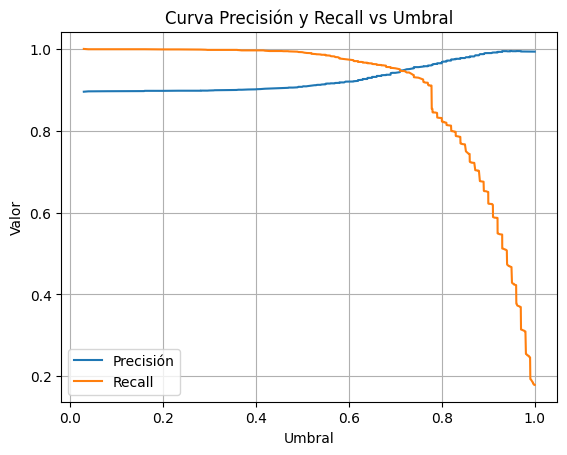

In [14]:
from sklearn.ensemble import RandomForestClassifier

# Entrena Random Forest con clase balanceada
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
clf.fit(X_train_tfidf, y_train)

# Predice probabilidades
y_proba = clf.predict_proba(X_test_tfidf)[:, 1]

# Selección de umbral óptimo según F1
thresh = np.arange(0.1, 0.9, 0.05)
f1s = [f1_score(y_test, y_proba >= t) for t in thresh]
max_f1 = max(f1s)
best_thresh = thresh[f1s.index(max_f1)]
print(f"\n>> [TF-IDF + RandomForest] Mejor F1-score: {max_f1:.4f} con umbral: {best_thresh:.2f}")

# Clasificación + matriz de confusión
y_pred_best = (y_proba >= best_thresh)
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot(cmap='Blues')
plt.title(f'Matriz de Confusión (TF-IDF + RandomForest, Umbral = {best_thresh:.2f})')
plt.grid(False)
plt.show()

# Curva F1 vs Umbral
plt.figure()
plt.plot(thresh, f1s, label='F1 Score')
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f'Máximo F1 = {max_f1:.4f}\nUmbral = {best_thresh:.2f}')
plt.scatter(best_thresh, max_f1, color='red')
plt.xlabel("Umbral")
plt.ylabel("F1 Score")
plt.title("F1 vs Umbral")
plt.legend()
plt.grid(True)
plt.show()

# Curva de Precisión-Recall
precision, recall, thresh_pr = precision_recall_curve(y_test, y_proba)
plt.figure()
plt.plot(thresh_pr, precision[:-1], label='Precisión')
plt.plot(thresh_pr, recall[:-1], label='Recall')
plt.xlabel('Umbral')
plt.ylabel('Valor')
plt.title('Curva Precisión y Recall vs Umbral')
plt.legend()
plt.grid(True)
plt.show()


## Vamos a intentar emplear un detector automático de ironías para intentar detectar los casos en los que las reseñas tienen un contenido irónico

In [15]:
%pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.9/796.9 kB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 85.6 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig
import torch

# Primero cargas la configuración del adapter
adapter_model = "TransferGraph/JonatanGk_roberta-base-bne-finetuned-cyberbullying-spanish-finetuned-lora-tweet_eval_irony"
config = PeftConfig.from_pretrained(adapter_model)

# Cargas el modelo base (sobre el que se entrenó el LoRA)
base_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path)

# Aplicar el adapter LoRA
irony_model = PeftModel.from_pretrained(base_model, adapter_model)

# Tokenizer del modelo base
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)

# Mover a dispositivo
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
irony_model.to(device)

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50262, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

## función de detección

In [17]:
from tqdm import tqdm

def detectar_ironia(textos, batch_size=16):
    irony_scores = []
    irony_model.eval()  # aseguramos modo inferencia
    for i in tqdm(range(0, len(textos), batch_size), desc="Detectando ironía"):
        batch = textos[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = irony_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)[:, 1]  # probabilidad de ironía
            irony_scores.extend(probs.cpu().numpy())
    return np.array(irony_scores)

Aplicamos la función

In [18]:
# Asegúrate de que X_train y X_test sean listas de strings
ironia_train = detectar_ironia(X_train.tolist())
ironia_test = detectar_ironia(X_test.tolist())

Detectando ironía: 100%|██████████| 176/176 [06:43<00:00,  2.29s/it]


Vemos que tal funciona

In [19]:
for i in range(10):
    print(f"📝 Review {i+1}: {X_train.values[i]}")
    print(f"✅ Etiqueta (recommended): {y_train.values[i]}")
    print(f"🎭 Probabilidad de ironía: {round(ironia_train[i], 4)}")
    print("-" * 80)

📝 Review 1: Es un juego en el que donde te guste minimamente los dinosaurios y la supervivencia, le vas a meter una viciada increible, engancha muchisimo, me atrevo a decir que es uno de los mejores juegos que nos daria esta experiencia dino-survival (sino el mejor). es disfrutable y si le agregas mods, provecho, no son precisamente pocos los que tiene, y muchos de ellos son una ampliacion enorme al juego para que tengas mas contenido si es lo que buscas.
Su mayor fallo es la optimizacion, pero si puedes correrlo, lo disfrutaras
✅ Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.5033000111579895
--------------------------------------------------------------------------------
📝 Review 2: DE 1 a 10 (UN 10)
✅ Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.3889000117778778
--------------------------------------------------------------------------------
📝 Review 3: No hay servidores en linea
✅ Etiqueta (recommended): False
🎭 Probabilidad de ironía: 0.2761000096797943
-----

Aplicamos la pipeline

In [20]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix

# === VECTORIZADORES Y MODELOS ===
vectorizers = {
    "CountVectorizer": CountVectorizer(max_features=2000),
    "TfidfVectorizer": TfidfVectorizer(max_features=2000)
}

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
}

# === EVALUACIÓN CON IRONÍA COMO FEATURE ===
resultados = []

for vec_name, vectorizer in vectorizers.items():
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    # Añadir ironía como feature adicional
    X_train_final = hstack([X_train_vec, ironia_train])
    X_test_final = hstack([X_test_vec, ironia_test])

    for model_name, model in models.items():
        model.fit(X_train_final, y_train)
        y_proba = model.predict_proba(X_test_final)[:, 1]

        # Buscar mejor umbral según F1
        thresholds = np.arange(0.1, 0.9, 0.05)
        f1s = [f1_score(y_test, y_proba >= t) for t in thresholds]
        best_f1 = max(f1s)
        best_thresh = thresholds[f1s.index(best_f1)]

        resultados.append({
            "Modelo": model_name,
            "Vectorizador": vec_name + " + Ironía",
            "F1-score": round(best_f1, 4),
            "Umbral óptimo": round(best_thresh, 2)
        })

# === MOSTRAR RESULTADOS ===
df_resultados = pd.DataFrame(resultados)
tabla_bonita = tabulate(df_resultados, headers='keys', tablefmt='fancy_grid', showindex=False)
print(tabla_bonita)


ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 1, expected 11241.

## Vamos a probar a hacer el análisis con un modelo de análisis de sentimientos 

Empleamos un modelo híbrido con análisis de sentimientos y la ironía para luego entrenar con ellos un clasificador básico

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np
from tqdm import tqdm

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
sentiment_model.eval()

def obtener_probas_sentimiento(textos, batch_size=16):
    probas = []
    for i in tqdm(range(0, len(textos), batch_size), desc="Obteniendo probas sentimiento"):
        batch = textos[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = sentiment_model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()  # shape: (B, 3)
            probas.extend(probs)
    
    return np.array(probas)  # shape: (N, 3)

2. Predecir las probabilidades

In [ ]:
# Obtenemos [negativo, neutro, positivo]
probas_train = obtener_probas_sentimiento(X_train.tolist())
probas_test = obtener_probas_sentimiento(X_test.tolist())

# Escogemos solo la probabilidad de positivo
proba_pos_train = probas_train[:, 2].reshape(-1, 1)
proba_pos_test = probas_test[:, 2].reshape(-1, 1)

# Concatenamos con la probabilidad de ironía (que ya tienes)
X_train_final = np.hstack([proba_pos_train, ironia_train.reshape(-1, 1)])
X_test_final = np.hstack([proba_pos_test, ironia_test.reshape(-1, 1)])

Obteniendo probas sentimiento: 100%|██████████| 176/176 [00:07<00:00, 22.90it/s]


3. Entrenamos el modelo híbrido

In [ ]:
from xgboost import XGBClassifier

modelo_final = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
modelo_final.fit(X_train_final, y_train)
y_pred = modelo_final.predict(X_test_final)

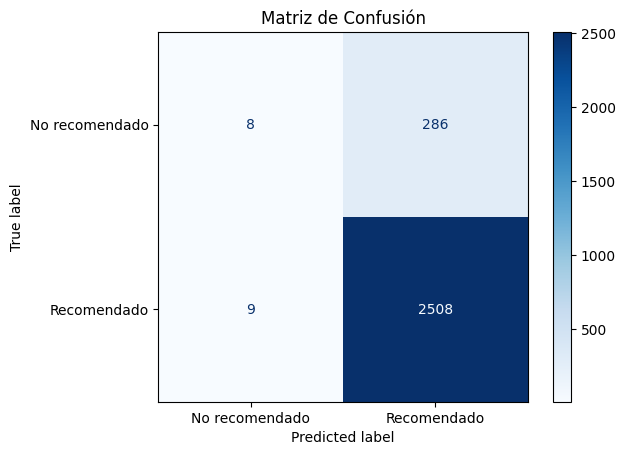

                precision    recall  f1-score   support

No recomendado       0.47      0.03      0.05       294
   Recomendado       0.90      1.00      0.94      2517

      accuracy                           0.90      2811
     macro avg       0.68      0.51      0.50      2811
  weighted avg       0.85      0.90      0.85      2811



In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No recomendado", "Recomendado"], cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_test, y_pred, target_names=["No recomendado", "Recomendado"]))

Ahora probamos binarizando la ironía de manera que solo si el valor es superior a 0.85 me de ironía 1 y sino cero.

In [ ]:
# Obtener los índices de los 5 valores máximos
top5_indices = ironia_train.argsort()[-5:][::-1]  # orden descendente

# Mostrar los resultados
for i, idx in enumerate(top5_indices):
    print(f"🔝 Review #{i+1}")
    print(f"📝 Texto: {X_train.values[idx]}")
    print(f"🎯 Etiqueta (recommended): {y_train.values[idx]}")
    print(f"🎭 Probabilidad de ironía: {ironia_train[idx]:.4f}")
    print("-" * 80)

🔝 Review #1
📝 Texto: un clásico para todas las edades, debería ser obligatorio como materia de primaria.
🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.7267
--------------------------------------------------------------------------------
🔝 Review #2
📝 Texto: El juego es simplemente hermoso

LE DEJO NEGATIVO, PORQUE NO TIENE SERVIDORES EN LATAM.

CUANDO HOSTEAS EL LOBBY TENES 4 DE PING
PERO CUANDO EMPIEZA LA MISION COOPERATIVA / PVP TE ENVIA A UN SERVER CON 144/146 DE PING
QUE ENCIMA NO SON REALES, PORQUE A VECES SE SIENTE COMO TENER CASI 200.
🎯 Etiqueta (recommended): False
🎭 Probabilidad de ironía: 0.7212
--------------------------------------------------------------------------------
🔝 Review #3
📝 Texto: buenas mecanicas, la historia te atrapa un poco, hay tension muchas veces y eso te hace sumergirte en el juego, la historia ni bien ni mal jajaja pero para el tipo de juego que es... encuentro que es algo lento por asi decirlo al momento de blandir el sable de luz y utili

In [ ]:
# Obtener los índices de los 5 valores mínimos
bottom5_indices = ironia_train.argsort()[:5]  # orden ascendente

# Mostrar los resultados
for i, idx in enumerate(bottom5_indices):
    print(f"🔽 Review #{i+1}")
    print(f"📝 Texto: {X_train.values[idx]}")
    print(f"🎯 Etiqueta (recommended): {y_train.values[idx]}")
    print(f"🎭 Probabilidad de ironía: {ironia_train[idx]:.4f}")
    print("-" * 80)

🔽 Review #1
📝 Texto: Mucha violencia lo que me gusta
🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.1318
--------------------------------------------------------------------------------
🔽 Review #2
📝 Texto: Que juegazo , primera vuelta terminada y hay que ir por mas , una pena que no salga el 2.
🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.1362
--------------------------------------------------------------------------------
🔽 Review #3
📝 Texto: ootto yey

🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.1441
--------------------------------------------------------------------------------
🔽 Review #4
📝 Texto: Mucha más variedad que en el primer juego
🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.1462
--------------------------------------------------------------------------------
🔽 Review #5
📝 Texto: juegazo, lastima que no tenga endgame

🎯 Etiqueta (recommended): True
🎭 Probabilidad de ironía: 0.1529
-------------------------------------

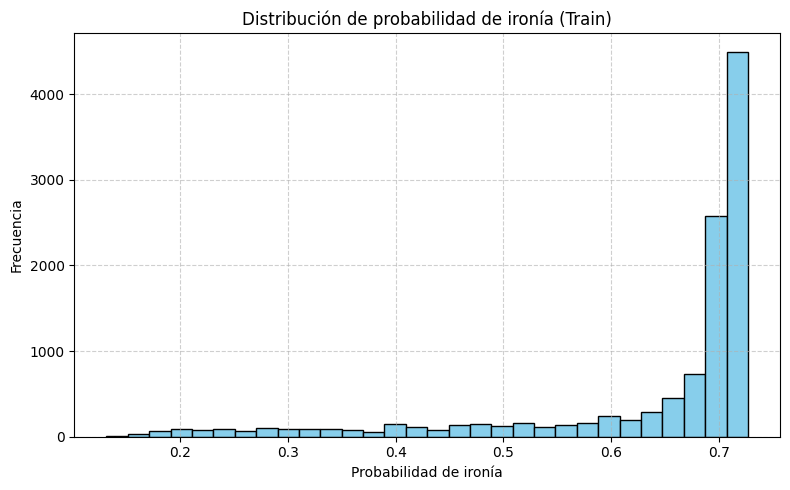

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(ironia_train, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribución de probabilidad de ironía (Train)")
plt.xlabel("Probabilidad de ironía")
plt.ylabel("Frecuencia")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
ironia_binaria = []

for valor in ironia_train:
    if valor >= 0.7:
        ironia_binaria.append(1)
    else:
        ironia_binaria.append(0)

# Convertir a array de NumPy si lo necesitas
ironia_binaria = np.array(ironia_binaria)
ironia_binaria = []

for valor in ironia_train:
    if valor >= 0.85:
        ironia_binaria.append(1)
    else:
        ironia_binaria.append(0)

# Convertir a array de NumPy si lo necesitas
ironia_binaria = np.array(ironia_binaria)

In [ ]:
# Concatenamos con la probabilidad de ironía (que ya tienes)
X_train_final = np.hstack([proba_pos_train, ironia_train.reshape(-1, 1)])
X_test_final = np.hstack([proba_pos_test, ironia_test.reshape(-1, 1)])

In [ ]:
from xgboost import XGBClassifier

modelo_final = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
modelo_final.fit(X_train_final, y_train)
y_pred = modelo_final.predict(X_test_final)

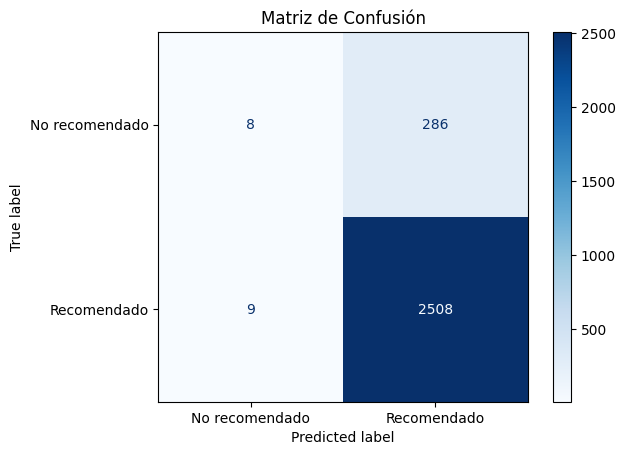

                precision    recall  f1-score   support

No recomendado       0.47      0.03      0.05       294
   Recomendado       0.90      1.00      0.94      2517

      accuracy                           0.90      2811
     macro avg       0.68      0.51      0.50      2811
  weighted avg       0.85      0.90      0.85      2811



In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["No recomendado", "Recomendado"], cmap="Blues")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_test, y_pred, target_names=["No recomendado", "Recomendado"]))